# Explaining US flight delays and cancellations
## by Natalya Bakhshetyan

## Investigation Overview

In this investigation, I wanted to explore US domestic flight data. The main focus is on flight delays, cancellations and their reasons.

## Dataset Overview

This document analyses US domestic flight data for years 2017 through 2019. Only January data is used. A random sample of 30,000 flights will be analysed, whereas the original data contains about 1.5 million flights. The original dataset was downloaded from http://stat-computing.org/dataexpo/2009/the-data.html.

In [5]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [6]:
#load the datasets into pandas DataFrames
flight_data1 = pd.read_csv("flight_data1.csv", dtype = {'DEP_TIME': object, 'ARR_TIME': object})
flight_data2 = pd.read_csv("flight_data2.csv", dtype = {'DEP_TIME': object, 'ARR_TIME': object})
flight_data3 = pd.read_csv("flight_data3.csv", dtype = {'DEP_TIME': object, 'ARR_TIME': object})

In [7]:
# sample 10,000 rows from each DataFrame for our analysis
sample_data1 = flight_data1.sample(n=10000, random_state=1)
sample_data2 = flight_data2.sample(n=10000, random_state=1)
sample_data3 = flight_data3.sample(n=10000, random_state=1)

In [8]:
#combine all 3 DataFrames into 1
combined_df = pd.concat([sample_data1, sample_data2, sample_data3])

In [9]:
#convert DAY_OF_WEEK to ordered categorical
def to_categorical(col, ordered_categories):
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordered_categories)
    combined_df[col] = combined_df[col].astype(ordered_var)

col = "DAY_OF_WEEK"
ordered_categories = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', "Saturday", 'Sunday']
combined_df[col] = combined_df[col].astype(str)
weekday_dict = {'1': 'Monday', '2' : "Tuesday", '3': 'Wednesday',
               '4': 'Thursday', '5': 'Friday', '6': 'Saturday',
               '7': 'Sunday'}
combined_df[col] = combined_df[col].replace(weekday_dict)
to_categorical(col, ordered_categories)

In [10]:
#convert DEP_DEL15 to string
combined_df['DEP_DEL15'] = combined_df['DEP_DEL15'].astype(str)

In [11]:
# rename DEP_DEL15 values to make them descriptive
delay_dict = {'0.0': '< 15 min', '1.0' : ">= 15 min"}
combined_df['DEP_DEL15'] = combined_df['DEP_DEL15'].replace(delay_dict)

In [12]:
#convert CANCELLATION_CODE to it's meaning
col = "CANCELLATION_CODE"
cancellation_code_dict = {'A': 'carrier', 'B' : "weather", 'C': 'NAS',
               'D': 'security'}
combined_df[col] = combined_df[col].replace(cancellation_code_dict)

In [13]:
#convert DEP_TIME and ARR_TIME from string to datetime.time
def float_to_datetime(col):    
    combined_df[col] = pd.to_datetime(combined_df[col], format='%H%M', errors = 'coerce').dt.time
    
float_to_datetime('DEP_TIME')
float_to_datetime('ARR_TIME')

## Flight Cancellation Rate

Let's take a look at which airporst have more cancellations. We will include only the top 30 busiest origin airports for our analysis. MDW has about 7 times more frequent cancellations than MIA. This may be due to particularly bad weather conditions, since the airport is located in the snowy city of Chicago and we are looking at January data exclusively. ORD is also located in Chicago, so it is not surprising that it has the second highest cancellation rate on this plot. The next 2 airports with the highest cancellation rates are JFK and BOS, which are both located in cities with cold climate, where there is a lot of snow in January. Overall, there are more airports located in colder cities on the left side of the plot and more airports located in warmer cities on the right side of the plot.

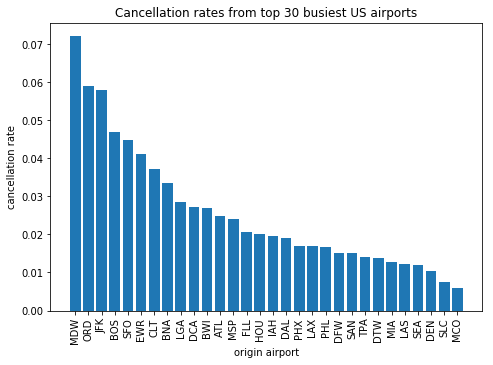

In [18]:
# get the list of top 30 airports from the database.
top_30_origin = combined_df['ORIGIN'].value_counts().head(30).keys()
#create a dataframe with top 30 airports
top_30_origin_df = combined_df[combined_df['ORIGIN'].isin(top_30_origin)]
#order origins based on mean cancellations
my_order = top_30_origin_df.groupby(by=['ORIGIN'])['CANCELLED'].mean().sort_values(ascending=False)
# plot the barchart
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
origin = my_order.index
mean_cancellation = my_order
ax.bar(origin,mean_cancellation)
plt.title('Cancellation rates from top 30 busiest US airports')
plt.xticks(rotation = 90)
plt.xlabel('origin airport')
plt.ylabel('cancellation rate')
plt.show()

## Cancellation Reasons

The following plot helps to visualize how much each cancellation reason contributes to overall cancellations for the top 10 busiest airports. Clearly, the most predominant cancellation reason for all airports is weather. The proportion of NAS and carrier delays is more variable between airports. PHX has no NAS cancellations at all, whereas there are way more NAS cancellations than carrier cancellations in ORD and SFO. Cancellations due to security are only present in LAX. In the last plot of this analysis we will also see that delays due to security reasons are also unique to LAX.

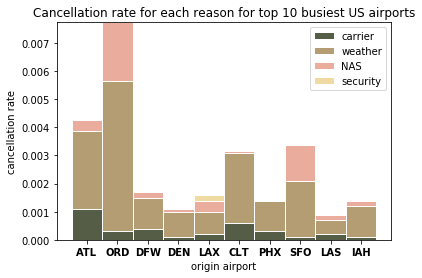

In [19]:
# get the list of top 10 busiest origin airports from the database.
top_10_origin = combined_df['ORIGIN'].value_counts().head(10).keys()

#create a dataframe with top 10 busiest origin airports
top_10_origin_df = combined_df[combined_df['ORIGIN'].isin(top_10_origin)]

def cancellation_code_rate(airport, cancellation_code):
    code_occurence = top_10_origin_df[(top_10_origin_df['ORIGIN'] == airport) & (top_10_origin_df['CANCELLATION_CODE'] == cancellation_code)].shape[0]
    return (code_occurence/top_10_origin_df.shape[0])

# Values of each group
bars1 = [cancellation_code_rate(airport, 'carrier') for airport in top_10_origin]
bars2 = [cancellation_code_rate(airport, 'weather') for airport in top_10_origin]
bars3 = [cancellation_code_rate(airport, 'NAS') for airport in top_10_origin]
bars4 = [cancellation_code_rate(airport, 'security') for airport in top_10_origin]

#cancellation reasons
cancellation_reasons = ['carrier', 'weather', 'NAS', 'security']

# Heights of bars1 + bars2
bars12 = np.add(bars1, bars2).tolist()

# Heights of bars1 + bars2 + bars3
bars123 = np.add(bars12, bars3).tolist()
 
# The position of the bars on the x-axis
r = [0,1,2,3,4,5,6,7,8,9]
 
# Names of group and bar width
names = list(top_10_origin)
barWidth = 1
 
# Create green bars
plt.bar(r, bars1, color='#565d47', edgecolor='white', width=barWidth)
# Create brown bars
plt.bar(r, bars2, bottom=bars1, color='#b49c73', edgecolor='white', width=barWidth)
# Create pink bars
plt.bar(r, bars3, bottom=bars12, color='#eaac9d', edgecolor='white', width=barWidth)
# Create yellow bars
plt.bar(r, bars4, bottom=bars123, color='#f0daa4', edgecolor='white', width=barWidth)
 
# axis, title, legend
plt.title('Cancellation rate for each reason for top 10 busiest US airports')
plt.xticks(r, names, fontweight='bold')
plt.xlabel("origin airport")
plt.ylabel('cancellation rate')
plt.legend(cancellation_reasons) 

# Show graphic
plt.show()


## Distribution of Departure Delays

Distribution of departure delays ranges from 1 minute to more than 1000 minutes. Although a lot of delays are within 40 minutes, many flights have delays greater than 40 minutes. The log scale of the plot makes it easier to visualize the distribution of more rare longer delays.

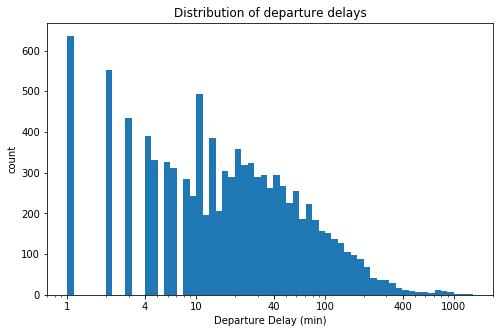

In [22]:
#setup bins
log_binsize = 0.05
bins = 10 ** np.arange(0, np.log10(combined_df['DEP_DELAY_NEW'].max())+log_binsize, log_binsize)

#plot
plt.figure(figsize=[8, 5])
plt.hist(data = combined_df, x = 'DEP_DELAY_NEW', bins = bins)
plt.xscale('log')
plt.xticks([1, 4, 10, 40, 100, 400, 1000], ['1', '4','10', '40', '100', '400', '1000'])
plt.title('Distribution of departure delays')
plt.xlabel('Departure Delay (min)')
plt.ylabel('count')
plt.show()

## Distribution of departure delays broken down to each type of delay and overall delay

Let's now take a look at the distribution of different delay types for the top 5 busiest airports. Just by looking at the ammount of data points on each plot, we can say that late aircraft delay is the most frequent delay reason. The least frequent delay reason is security delay. Actually, in this particular sample, there are only 2 security delay incidents, both of which are in LAX. Not suprisingly, LAX has fewer and shorter weather delays compared to other airports, but surprisingly DEN has about the same weather delay distribution as LAX. This is unusual, since Denver is located in a cold place, where it snows in the winter like in Atlanta (ATL) and Chicago (ORD). DFW weather delay distribution is for the most part similar to LAX, with just one 200+ minute delay. NAS delays are fewer and shorter in LAX and DFW. Carrier delays are fewer and shorter in DEN.

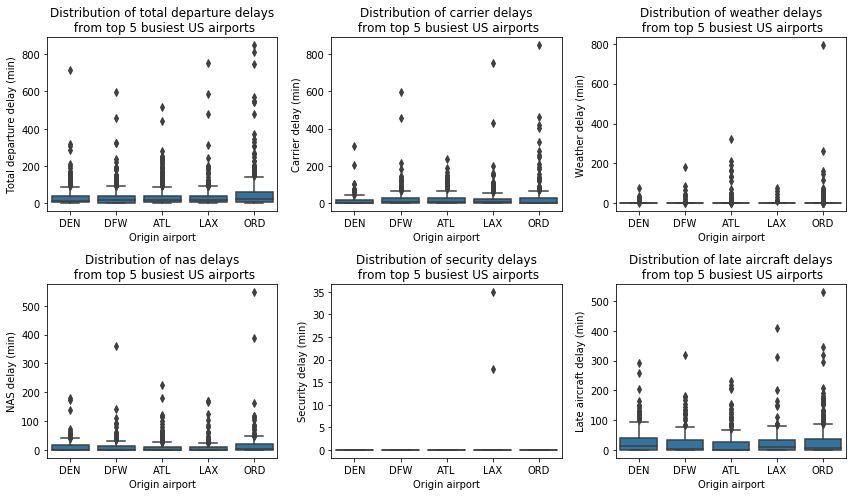

In [37]:
# get the list of top 5 airports from the dataset.
top_5_origin = combined_df['ORIGIN'].value_counts().head(5).keys()
#create a dataframe with top 5 airports, including fligths with delays only
top_5_origin_df = combined_df[combined_df['ORIGIN'].isin(top_5_origin) & combined_df['DEP_DELAY_NEW'] > 0]
#rename columns to get proper labels for y-axis
top_5_origin_df = top_5_origin_df.rename(columns={'DEP_DELAY_NEW': "Total departure delay (min)", 'CARRIER_DELAY': "Carrier delay (min)", 
                                'WEATHER_DELAY': "Weather delay (min)", 'NAS_DELAY': 'NAS delay (min)',
                               'SECURITY_DELAY': 'Security delay (min)', 'LATE_AIRCRAFT_DELAY': 'Late aircraft delay (min)'})

#list of y variables
yvars = ['Total departure delay (min)', 'Carrier delay (min)', 
         'Weather delay (min)', 'NAS delay (min)', 'Security delay (min)',
        'Late aircraft delay (min)']

#plot
plt.subplots(2,3,figsize=(12,7))
count = 1
default_color = sb.color_palette()[0]
for yvar in yvars:
    plt.subplot(2,3, count)
    sb.boxplot(x= "ORIGIN", y=yvar, data=top_5_origin_df, color= default_color)
    plt.title('Distribution of ' + (yvar.split(' (')[0]).lower() + 's' + '\n from top 5 busiest US airports')
    plt.xlabel('Origin airport')
    plt.ylabel(yvar)
    plt.tight_layout()
    count +=1

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!